In [186]:
cd /orange/adamginsburg/salt/maud/

/orange/adamginsburg/salt/maud


In [187]:
ls

G17_SPW0_2017.image.fits  G17_SPW3_2017.image.fits    spectra/
G17_SPW1_2017.image.fits  KCl_v_le_3_stackcube.fits
G17_SPW2_2017.image.fits  NaCl_v_le_3_stackcube.fits


In [188]:
%matplotlib inline
import pylab as pl
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x2b0387387c40>

In [302]:
from astropy.table import Table
from astropy import table

In [318]:
import pprint

In [189]:
import scipy, scipy.ndimage

In [190]:
import numpy as np
import os
import glob
from astropy import constants, units as u, table, stats, coordinates, wcs, log, coordinates as coord
import radio_beam
import pyspeckit
import pylab as pl
from astroquery.splatalogue.utils import minimize_table as mt
import sys
sys.path.append('/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis')
import lines
import paths
from salt_tables import (salt_tables, salt_table_names, SO, SO2, HCl, sis_tables, AlCl, AlF, Al37Cl,
                         NaF, AlO, AlOH, NaCN, CaS, CaO)

In [191]:
import regions
from astropy import units as u, coordinates
reg = regions.CircleSkyRegion(coordinates.SkyCoord('18h22m26.385s −13:30:11.9700', frame='icrs', unit=(u.h, u.deg)), radius=0.4*u.arcsec)
regsm = regions.CircleSkyRegion(coordinates.SkyCoord('18h22m26.385s −13:30:11.9700', frame='icrs', unit=(u.h, u.deg)), radius=0.3*u.arcsec)
regvsm = regions.CircleSkyRegion(coordinates.SkyCoord('18h22m26.385s −13:30:11.9700', frame='icrs', unit=(u.h, u.deg)), radius=0.15*u.arcsec)

# NaCl Stackl

In [192]:
from spectral_cube.analysis_utilities import stack_cube

In [193]:
nacltables = salt_tables[3:5]
nacltables[0]

Iso,Ju,Jl,vu,vl,nuCalc,e_nuCalc,x_nuCalc,E_U,Aij,Freq,gu,gl,E_L,QNs,Species
,,,,,,,,K,1 / s,GHz,,,,,
str2,int16,int16,uint8,uint8,float64,float64,str9,float64,float32,float64,int16,int16,float64,str15,str24
35,1,0,8,8,12268.92600,0.002000,MHz,4019.50,7e-07,12.268926,48,16,4018.9111844187687,v=8-8 J=1-0,23Na-35Clv=8-8 J=1-0
35,1,0,7,7,12361.41100,0.001000,MHz,3534.10,7e-07,12.361411,48,16,3533.506745838812,v=7-7 J=1-0,23Na-35Clv=7-7 J=1-0
35,1,0,6,6,12454.51100,0.001000,MHz,3043.90,7e-07,12.454511,48,16,3043.302277743511,v=6-6 J=1-0,23Na-35Clv=6-6 J=1-0
35,1,0,5,5,12548.22800,0.000000,MHz,2548.90,7e-07,12.548228,48,16,2548.29778003688,v=5-5 J=1-0,23Na-35Clv=5-5 J=1-0
35,1,0,4,4,12642.56100,0.000000,MHz,2049.20,7e-07,12.642561,48,16,2048.593252766911,v=4-4 J=1-0,23Na-35Clv=4-4 J=1-0
35,1,0,3,3,12737.51100,0.000000,MHz,1544.50,7e-07,12.737511000000001,48,16,1543.8886958856133,v=3-3 J=1-0,23Na-35Clv=3-3 J=1-0
35,1,0,2,2,12833.07700,0.000000,MHz,1034.90,7e-07,12.833077,48,16,1034.2841094409778,v=2-2 J=1-0,23Na-35Clv=2-2 J=1-0
35,1,0,1,1,12929.26100,0.000000,MHz,520.30,7e-07,12.929261,48,16,519.6794933370201,v=1-1 J=1-0,23Na-35Clv=1-1 J=1-0


In [320]:
import spectral_cube.analysis_utilities
import imp
imp.reload(spectral_cube.analysis_utilities)
from spectral_cube.analysis_utilities import stack_cube

In [195]:
cubes = [SpectralCube.read(fn).subcube_from_regions([reg]) for fn in (glob.glob('G17_SPW[0-3]_2017.image.fits'))]

beams = radio_beam.Beams(beams=[cube.beams.common_beam() for cube in cubes])
cb=beams.common_beam()

linelist = np.concatenate([data['Freq'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)].quantity
                             for data in nacltables])
linenames = np.concatenate( [data['Species'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)]
                             for data in nacltables] )
(linelist, linenames)

(<Quantity [217.980231, 219.614936, 232.509977, 234.251912] GHz>,
 array(['23Na-35Clv=2-2 J=17-16', '23Na-35Clv=1-1 J=17-16',
        '23Na-35Clv=1-1 J=18-17', '23Na-35Clv=0-0 J=18-17'], dtype='<U24'))

In [196]:
[data['Species'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)]
                             for data in nacltables]

[<Column name='Species' dtype='str24' length=4>
 23Na-35Clv=2-2 J=17-16
 23Na-35Clv=1-1 J=17-16
 23Na-35Clv=1-1 J=18-17
 23Na-35Clv=0-0 J=18-17,
 <Column name='Species' dtype='str24' length=0>]

In [197]:
from astropy import log
log.setLevel('INFO')

In [198]:
#log.setLevel('DEBUG')
stack, cutouts = stack_cube(cubes,
                   linelist=linelist,
                   vmin=-10*u.km/u.s,
                   vmax=50*u.km/u.s,
                   average=np.nanmean,
                   convolve_beam=cb,
                   return_cutouts=True)
#log.setLevel('INFO')
stack.writeto('NaCl_v_le_3_stackcube.fits', overwrite=True)

Mean of empty slice


In [199]:
stackc = SpectralCube.read('NaCl_v_le_3_stackcube.fits')
stackc

SpectralCube with shape=(49, 159, 160) and unit=Jy / beam:
 n_x:    160  type_x: RA---SIN  unit_x: deg    range:   275.609824 deg:  275.610051 deg
 n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -13.503435 deg:  -13.503215 deg
 n_s:     49  type_s: VRAD      unit_s: km / s  range:      -10.289 km / s:      50.153 km / s

All-NaN slice encountered
invalid value encountered in true_divide


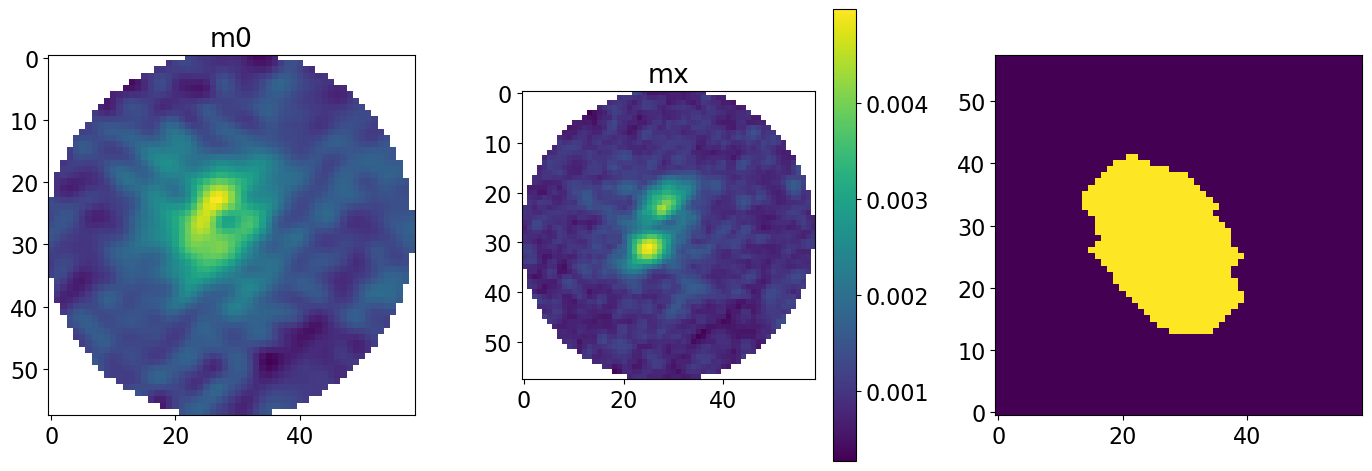

<Figure size 640x480 with 0 Axes>

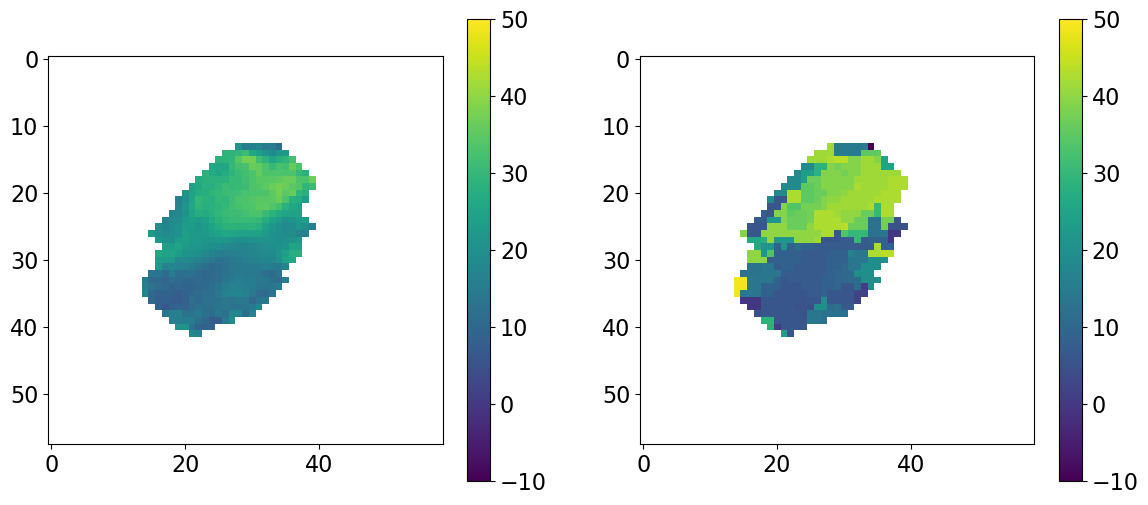

In [250]:
stackc = stackc.subcube_from_regions([regvsm])
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = stackc.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = stackc.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 0.0016*mx.unit
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=5)
pl.imshow(msk, interpolation='none', origin='lower')
pl.tight_layout()
pl.figure()


m1 = stackc.with_mask(msk).with_mask(stackc > 0.0005*stackc.unit).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=-10, vmax=50)
pl.colorbar(mappable=im)
mxv = stackc.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=-10, vmax=50)
pl.colorbar()


vmap = mxv.hdu

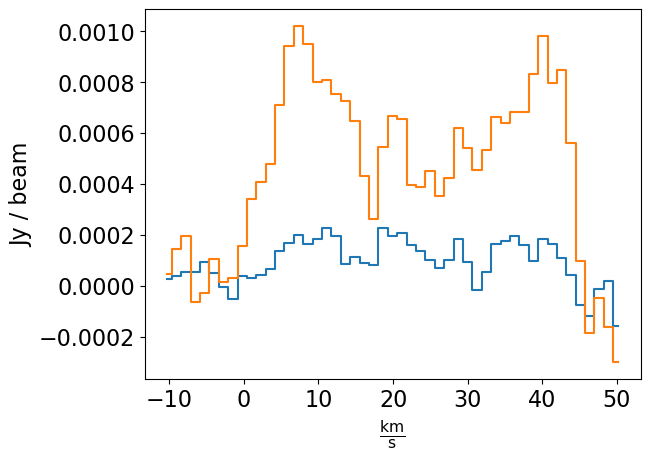

In [201]:
stackc.mean(axis=(1,2)).quicklook()
stackc.with_mask(msk).mean(axis=(1,2)).quicklook()

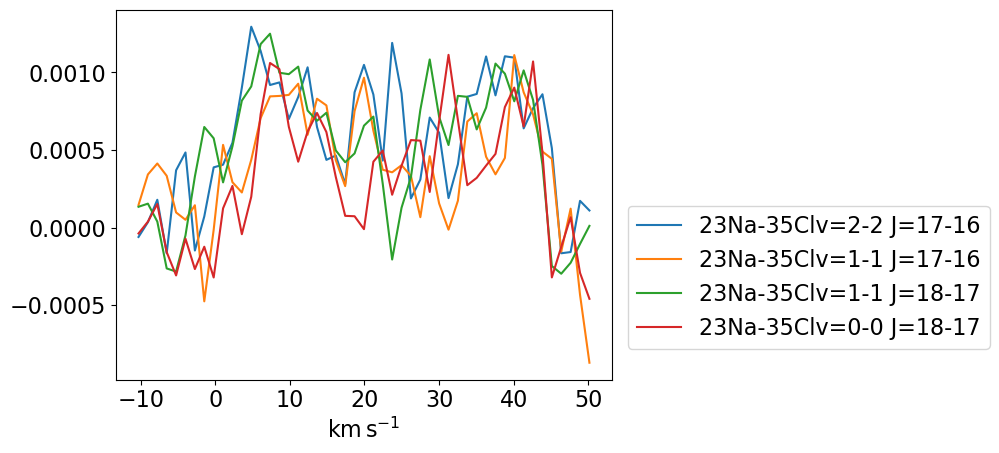

In [202]:
for cutout, linef in zip(cutouts, linenames):
    cutout = SpectralCube(data=cutout, header=stack.header, wcs=wcs.WCS(stack.header)).subcube_from_regions([regvsm])
    sp = cutout.with_mask(msk).mean(axis=(1,2))
    pl.plot(sp.spectral_axis, sp.value, label=str(linef))
    pl.legend(loc='upper left', bbox_to_anchor=(1.01,0.5,0,0))

# Past exploration of vmap

In [203]:
cubespw2 = SpectralCube.read('G17_SPW2_2017.image.fits', use_dask=True).subcube_from_regions([reg])
cubespw2

DaskVaryingResolutionSpectralCube with shape=(1920, 159, 160) and unit=Jy / beam and chunk size (320, 86, 123):
 n_x:    160  type_x: RA---SIN  unit_x: deg    range:   275.609824 deg:  275.610051 deg
 n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -13.503435 deg:  -13.503215 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 230937801859.600 Hz:232811916796.997 Hz

Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.


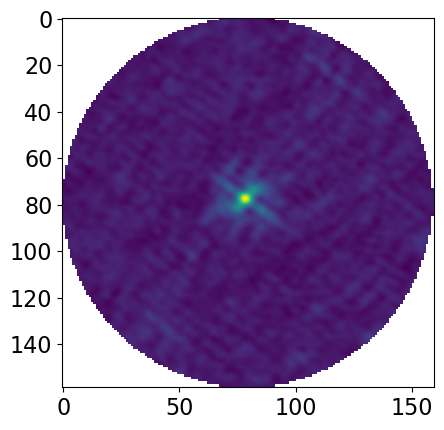

In [204]:
m0 = cubespw2.spectral_slab(231.8187*u.GHz, 231.9154*u.GHz).moment0()
m0.quicklook()

naclv1 = cubespw2.subcube_from_regions([regvsm]).with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=232509.97700*u.MHz).spectral_slab(0*u.km/u.s, 40*u.km/u.s)
m0 = naclv1.moment0()
m0.quicklook()

mx = naclv1.max(axis=0)
mx.quicklook()
pl.colorbar()
msk = mx > 0.00245*mx.unit
msk = scipy.ndimage.binary_dilation(scipy.ndimage.binary_erosion(msk, iterations=1), iterations=7)
pl.imshow(msk)
pl.figure()


m1 = naclv1.with_mask(msk).with_mask(naclv1 > 0.0005*naclv1.unit).moment1()
pl.imshow(m1.value, vmin=0, vmax=40)
pl.colorbar()
vmap = m1.hdu

cubespw3 = SpectralCube.read('G17_SPW3_2017.image.fits', use_dask=True).subcube_from_regions([reg])

naclv0 = cubespw3.subcube_from_regions([regvsm]).with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=234251.91200*u.MHz).spectral_slab(0*u.km/u.s, 40*u.km/u.s)
m0 = naclv0.moment0()
m0.quicklook()

mx = naclv0.max(axis=0)
mx.quicklook()
pl.colorbar()
msk = mx > 0.004*mx.unit
msk = scipy.ndimage.binary_dilation(scipy.ndimage.binary_erosion(msk, iterations=1), iterations=7)
pl.imshow(msk)
pl.figure()


m1 = naclv0.with_mask(msk).with_mask(naclv0 > 0.0005*naclv1.unit).moment1()
pl.imshow(m1.value, vmin=0, vmax=40)
pl.colorbar()
vmap = m1.hdu



In [205]:
cubespw1 = SpectralCube.read('G17_SPW1_2017.image.fits', use_dask=True).subcube_from_regions([reg])
cubespw1

DaskVaryingResolutionSpectralCube with shape=(1920, 159, 160) and unit=Jy / beam and chunk size (320, 86, 123):
 n_x:    160  type_x: RA---SIN  unit_x: deg    range:   275.609824 deg:  275.610051 deg
 n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -13.503435 deg:  -13.503215 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 218854211902.303 Hz:220728326839.700 Hz

Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.


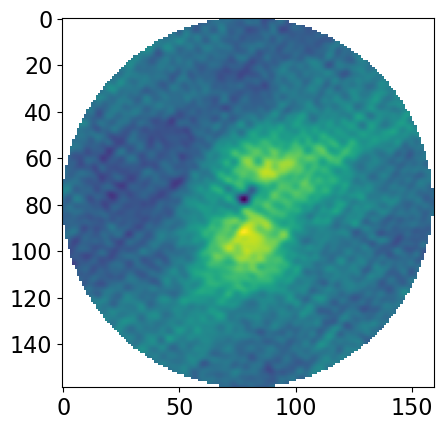

In [206]:
m0 = cubespw1.spectral_slab(219.9246*u.GHz, 219.9422*u.GHz).moment0()
m0.quicklook()

Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.


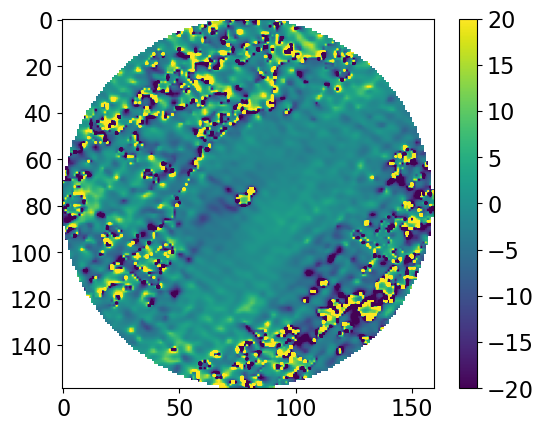

In [207]:
m1 = cubespw1.spectral_slab(219.9246*u.GHz, 219.9422*u.GHz).with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=219.9320*u.GHz).moment1()
m1.quicklook()
pl.imshow(m1.value, vmin=-20, vmax=20)
pl.colorbar()

In [208]:
import glob
import pyspeckit

<Figure size 640x480 with 0 Axes>

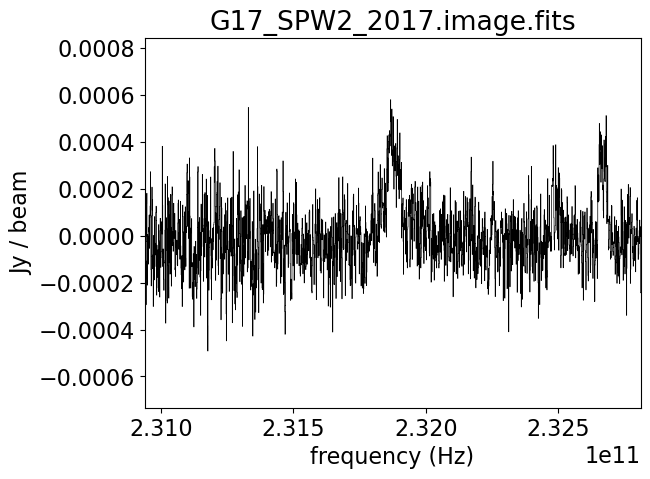

<Figure size 640x480 with 0 Axes>

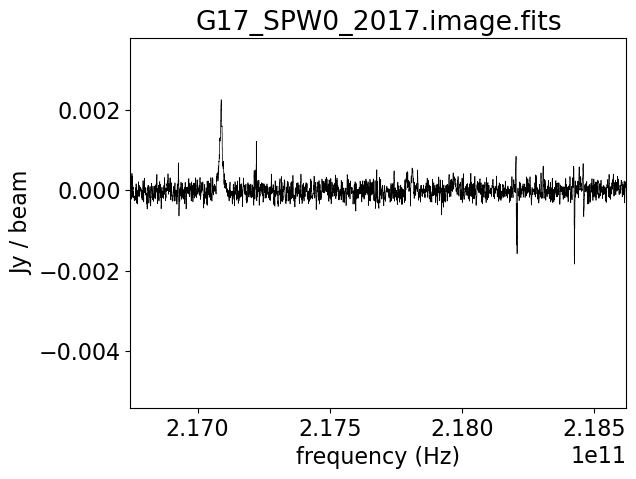

<Figure size 640x480 with 0 Axes>

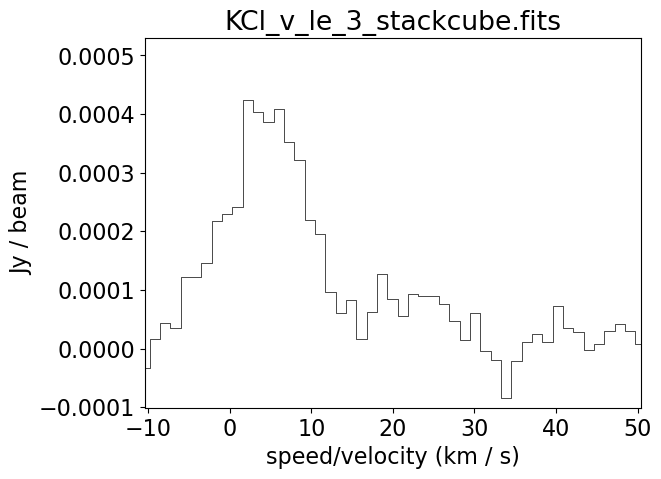

<Figure size 640x480 with 0 Axes>

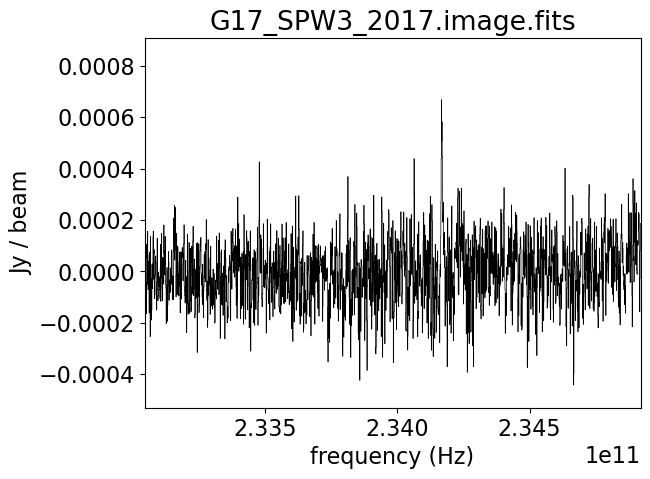

<Figure size 640x480 with 0 Axes>

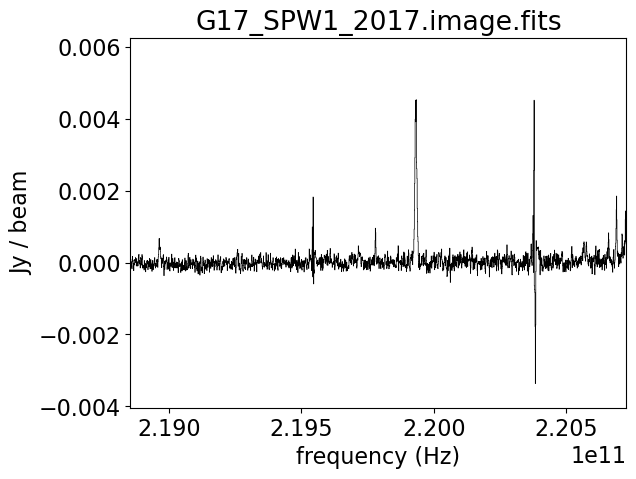

<Figure size 640x480 with 0 Axes>

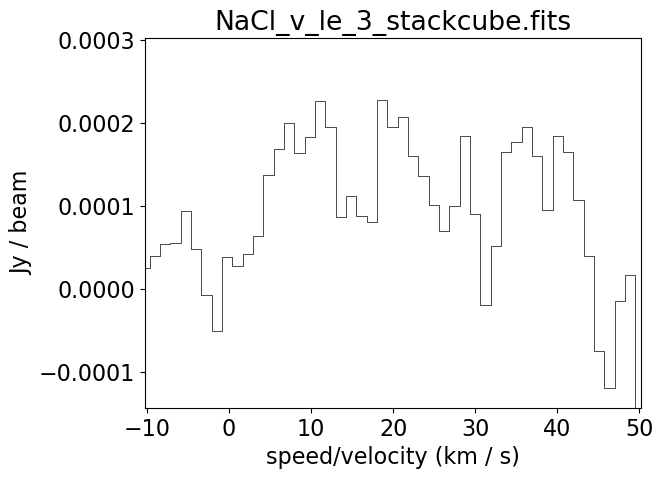

In [209]:
spectra = []
for fn in glob.glob("*.fits"):
    cube = SpectralCube.read(fn).subcube_from_regions([regvsm])
    sp = pyspeckit.Spectrum(xarr=cube.spectral_axis, data=cube.mean(axis=(1,2)))
    pl.figure()
    sp.plotter()
    pl.title(fn)
    
    sp.specname = fn
    
    spectra.append(sp)

sp.plotter(xmin=219.8e9, xmax=220.0e9)
sp.specfit(gueses=[0.002, 219.98e9, 0.01e9])

In [210]:
from astroquery.splatalogue import Splatalogue
from astropy import constants

frq = sp.specfit.parinfo[1].value*u.Hz
vel = 0*u.km/u.s # 22*u.km/u.s
width = 5*u.km/u.s
fmin = frq * (1-(vel+width)/constants.c)
fmax = frq * (1-(vel-width)/constants.c)
Splatalogue.query_lines(fmin, fmax, line_lists=['JPL']).pprint(max_lines=1000, max_width=250)

DaskVaryingResolutionSpectralCube with shape=(1920, 512, 512) and unit=Jy / beam and chunk size (320, 256, 256):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   275.609511 deg:  275.610241 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -13.503689 deg:  -13.502979 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 230937801859.600 Hz:232811916796.997 Hz


DaskVaryingResolutionSpectralCube with shape=(3840, 512, 512) and unit=Jy / beam and chunk size (320, 256, 256):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   275.609511 deg:  275.610241 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -13.503689 deg:  -13.502979 deg
 n_s:   3840  type_s: FREQ      unit_s: Hz     range: 216746373866.513 Hz:218620977109.000 Hz


DaskVaryingResolutionSpectralCube with shape=(1920, 512, 512) and unit=Jy / beam and chunk size (320, 256, 256):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   275.609511 deg:  275.610241 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -13.503689 deg:  -13.502979 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 233045395742.900 Hz:234919510680.414 Hz


DaskVaryingResolutionSpectralCube with shape=(1920, 512, 512) and unit=Jy / beam and chunk size (320, 256, 256):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   275.609511 deg:  275.610241 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -13.503689 deg:  -13.502979 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 218854211902.303 Hz:220728326839.700 Hz


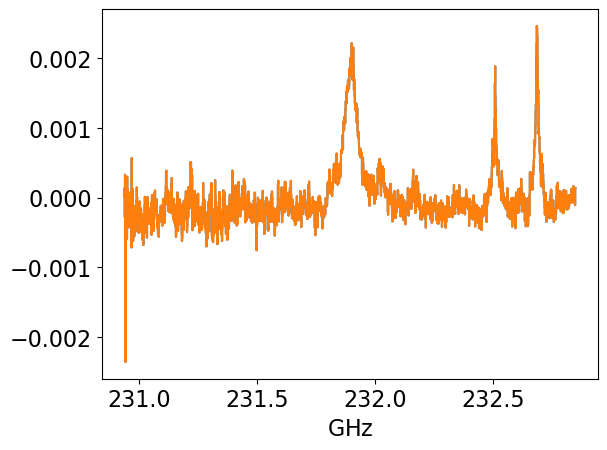

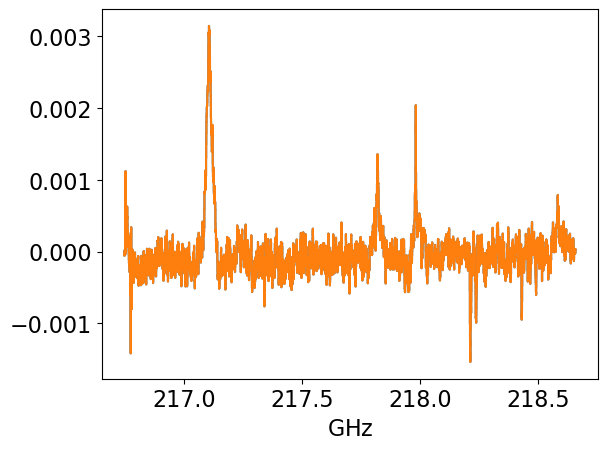

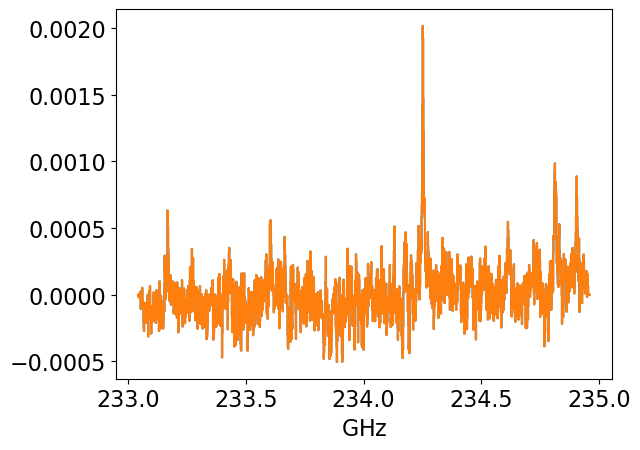

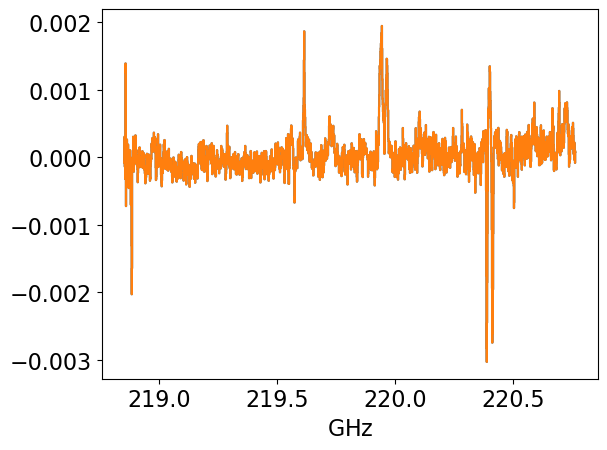

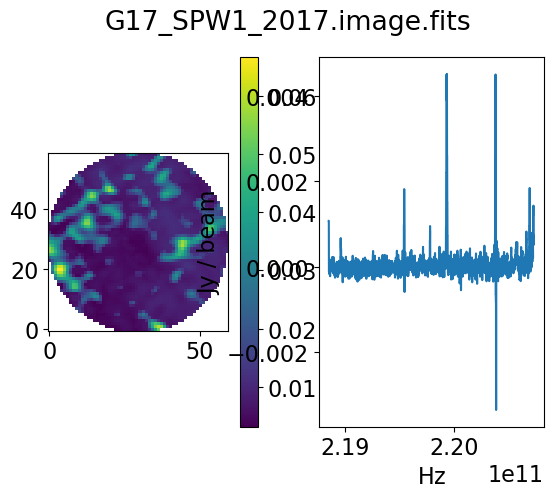

In [211]:
import glob
import spectral_cube.analysis_utilities
import reproject

flist = [x for x in glob.glob('*.fits') if 'spectra' not in x]
flist = glob.glob('G17_SPW[0-3]_2017.image.fits')
for fn in flist:
    basename = os.path.split(fn)[-1].split(".fits")[0]
    try:
        cube = SpectralCube.read(fn, use_dask=True)
    except Exception as ex:
        print(ex)
        continue
    print(cube)
    scube = cube.subcube_from_regions([regvsm])
    mx = scube.max(axis=0)
    #msk = mx > 0.003*mx.unit
    sp = scube.mean(axis=(1,2))
    
    sp.write(f'spectra/{fn.split("/")[-1].replace(".fits","_meanspec.fits")}', overwrite=True)

    # convert the cube to velocity units with an arbitrary reference point
    # (this step assumes the cube is in frequency or wavelength; if the
    # cube is not, it should be skipped)
    if not cube.spectral_axis.unit.is_equivalent(u.km/u.s):
        fullcube = cube.with_spectral_unit(u.km/u.s,
                                           velocity_convention='radio',
                                           rest_value=cube.spectral_axis.mean())
    else:
        fullcube = cube

    # force the fullcube to be a regular cube, not varying res
    # (resolution variation is negligible and I don't want to spend time smoothing)
    commonbeam = fullcube.beams.common_beam()
    fullcube = SpectralCube(data=fullcube._data, wcs=fullcube.wcs, beam=commonbeam, mask=fullcube.mask,)

    scube = fullcube.subcube_from_regions([regvsm])#.convolve_to(fullcube.beams.common_beam())

    # reproject the velocity map into the cube's coordinate system
    vmap_proj,_ = reproject.reproject_interp(vmap,
                                             scube.wcs.celestial,
                                             shape_out=scube.shape[1:])
    vmap_proj = u.Quantity(vmap_proj, u.km/u.s)


    # perform the stacking!
    stack = spectral_cube.analysis_utilities.stack_spectra(scube, vmap_proj,
                                                           v0=0.0*u.km/u.s)
    fstack = stack.with_spectral_unit(u.GHz)

    pl.suptitle(f"{fn}")
    fstack.write(f'spectra/{basename}_stack.fits', overwrite=True)

    pl.clf()
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.pdf')
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.png')
    
    
    fig = pl.figure()
    mappable = pl.subplot(1,2,1).imshow(mx.value, origin='lower', interpolation='none')
    pl.colorbar(mappable)
    pl.subplot(1,2,2)
    pl.suptitle(fn)
    sp.quicklook()

<Figure size 640x480 with 0 Axes>

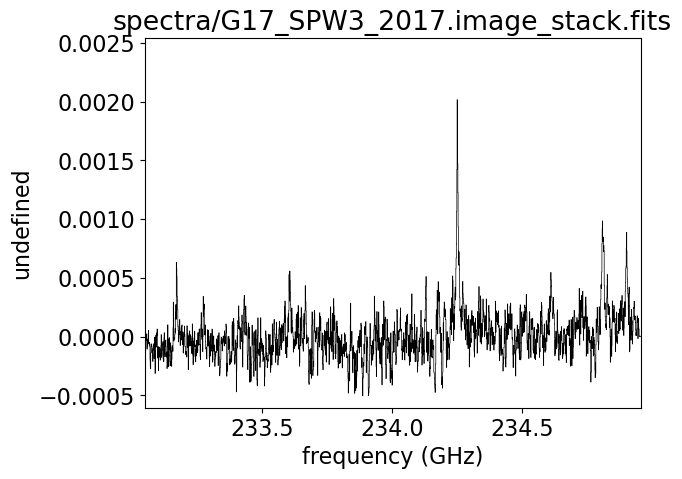

<Figure size 640x480 with 0 Axes>

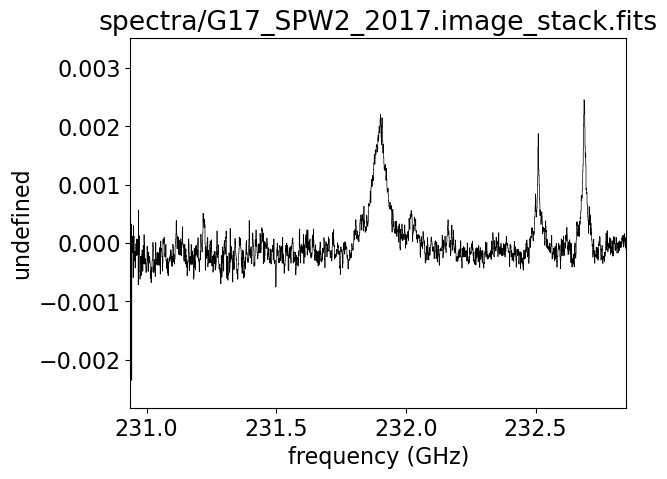

<Figure size 640x480 with 0 Axes>

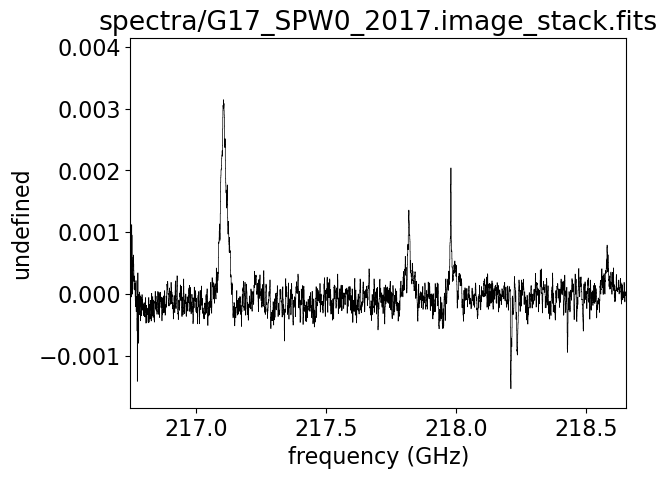

<Figure size 640x480 with 0 Axes>

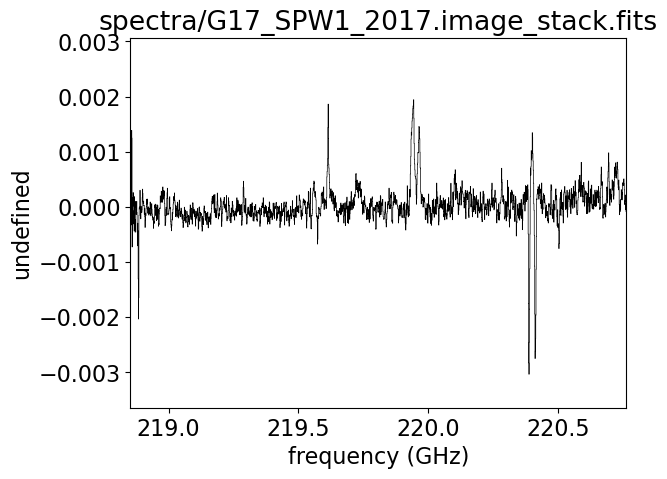

In [212]:
spectra = []
for fn in glob.glob("spectra/*stack.fits"):

    sp = pyspeckit.Spectrum(fn)
    pl.figure()
    sp.plotter()
    pl.title(fn)
    
    sp.specname = fn
    
    spectra.append(sp)

In [213]:
if not os.path.exists('spectra'):
    os.mkdir('spectra')
if not os.path.exists('spectra/figures'):
    os.mkdir('spectra/figures')   

G17_SPW3_2017.image_stack.fits
[('39K-35Clv=3-3 J=31-30', <Quantity 233.60569798 GHz>), ('39K-37Clv=3-3 J=32-31', <Quantity 234.33493148 GHz>), ('41K-35Clv=4-4 J=32-31', <Quantity 234.18192351 GHz>), ('23Na-35Clv=0-0 J=18-17', <Quantity 234.251912 GHz>), ('23Na-37Clv=4-4 J=19-18', <Quantity 234.904242 GHz>), ('41K-37Clv=4-4 J=33-32', <Quantity 234.54382952 GHz>), ('KCl v=3 31-30', <Quantity 233.60569798 GHz>), ('Na$^{37}$Cl v=5 J=19-18', <Quantity 233.1645843 GHz>)]
G17_SPW2_2017.image_stack.fits
[('39K-35Clv=4-4 J=31-30', <Quantity 232.16184646 GHz>), ('39K-37Clv=0-0 J=31-30', <Quantity 231.21883931 GHz>), ('41K-35Clv=1-1 J=31-30', <Quantity 231.08814962 GHz>), ('41K-35Clv=0-0 J=31-30', <Quantity 232.49980161 GHz>), ('23Na-35Clv=1-1 J=18-17', <Quantity 232.509977 GHz>), ('41K-37Clv=1-1 J=32-31', <Quantity 231.60913137 GHz>), ('$^{41}$KCl 31-30', <Quantity 232.49984 GHz>), ('H$_2$O v$_2$=1 $5_{5,0}-6_{4,3}$', <Quantity 232.6867 GHz>), ('H30$\\alpha$', <Quantity 231.900928 GHz>), ('KCl 

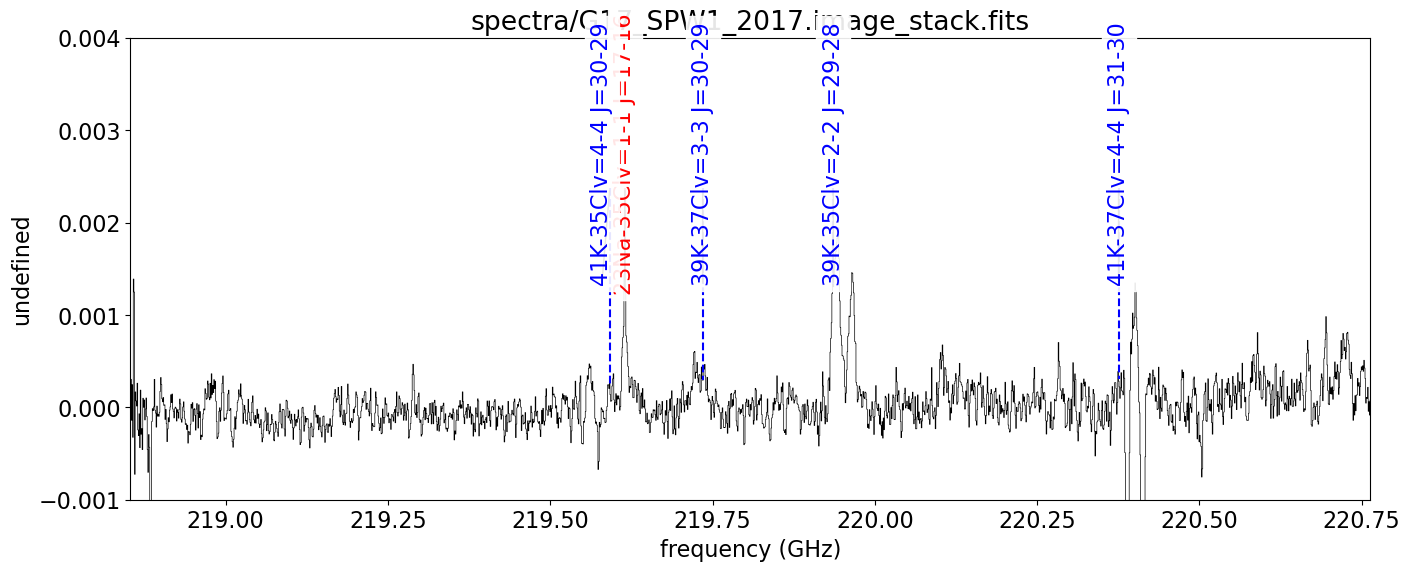

In [214]:
# (vcen in the stacked centroid is defined to be zero)
vcen = 0*u.km/u.s

pl.matplotlib.rcParams['font.size']=16

all_lines = {**lines.disk_lines, **lines.absorbers}

ided_linenames = sorted(all_lines.keys())
ided_linefreqs = u.Quantity([all_lines[x] for x in ided_linenames
                             #if 'U' not in x
                            ])
ided_linetexnames = [lines.texnames[x] if x in lines.texnames else x
                     for x in ided_linenames
                     #if 'U' not in x
                    ]

#salt_tables = [KCl, K37Cl, K41Cl, NaCl, Na37Cl, K41Cl37]
salt_colors = ['b', 'm', 'darkgreen', 'orange', 'c', 'y']

tables = salt_tables

def linename(row):
    return row['Species'] #"{0} {1}".format(row['Species'], row['QNs'])
def freq(row):
    return u.Quantity(row['Freq'], u.GHz)

linenames = [linename(row) for tbl in tables for row in tbl if row['vu'] <=4]
linetexnames = [linename(row) for tbl in tables for row in tbl if row['vu'] <=4] + ided_linetexnames
linetexnames = np.array(linetexnames)
linefreqs = np.hstack([u.Quantity([freq(row) for tbl in tables for row in tbl if row['vu'] <=4], u.GHz).value,
                       ided_linefreqs.value])
linefreqs = u.Quantity(linefreqs, u.GHz)


detection_table = table.Table.read(paths.tpath('salts_in_band.ipac'), format='ascii.ipac')
nondetections = (detection_table['Flag'] == '-n') | (detection_table['Flag'] == 'cn')
detection_table = detection_table[~nondetections]

paths.fpath = lambda x: f"spectra/figures/{x}"

for sp_st in spectra:
    
    sp_st.xarr.convert_to_unit(u.GHz)
    
    basefn = os.path.basename(sp_st.specname)
    print(basefn)
    
    pl.figure(0, figsize=(16,6)).clf()
    sp_st.plotter(figure=pl.figure(0, figsize=(16,6)), clear=True)

    lines_to_plot = ((linefreqs > sp_st.xarr.as_unit(linefreqs.unit).min()*(1-vcen/constants.c)) &
                     (linefreqs < sp_st.xarr.as_unit(linefreqs.unit).max()*(1+vcen/constants.c)))
    print(list(zip(linetexnames[lines_to_plot], linefreqs[lines_to_plot])))
    
    ymax = sp_st.data.max()
    ymin = sp_st.data.min()
    if ymax < 0.004:
        ymax = 0.004
    if ymin < -0.001:
        ymin = -0.001
    sp_st.plotter(ymax=ymax, ymin=ymin)
    
    sp_st.plotter.line_ids(linetexnames[lines_to_plot], linefreqs[lines_to_plot], velocity_offset=vcen,
                           label1_size=16,
                           auto_yloc_fraction=0.75)
    for txt in sp_st.plotter.axis.texts:
        txt.set_backgroundcolor((1,1,1,0.9))


    sp_st.plotter.savefig(paths.fpath('{0}'
                                      .format(basefn.replace("fits","png")))
                          )

    for obj in sp_st.plotter.axis.texts+sp_st.plotter.axis.lines:
        if 'Na' in obj.get_label():
            obj.set_color('r')
            obj.set_zorder(5)
        elif 'K' in obj.get_label():
            obj.set_color('b')
            obj.set_zorder(10)
    for txt in sp_st.plotter.axis.texts:
        txt.set_backgroundcolor((1,1,1,0.9))

    sp_st.plotter.savefig(paths.fpath('color_labels_{0}'
                                      .format(basefn.replace("fits","png")))
                          )

In [215]:
from IPython.display import Image

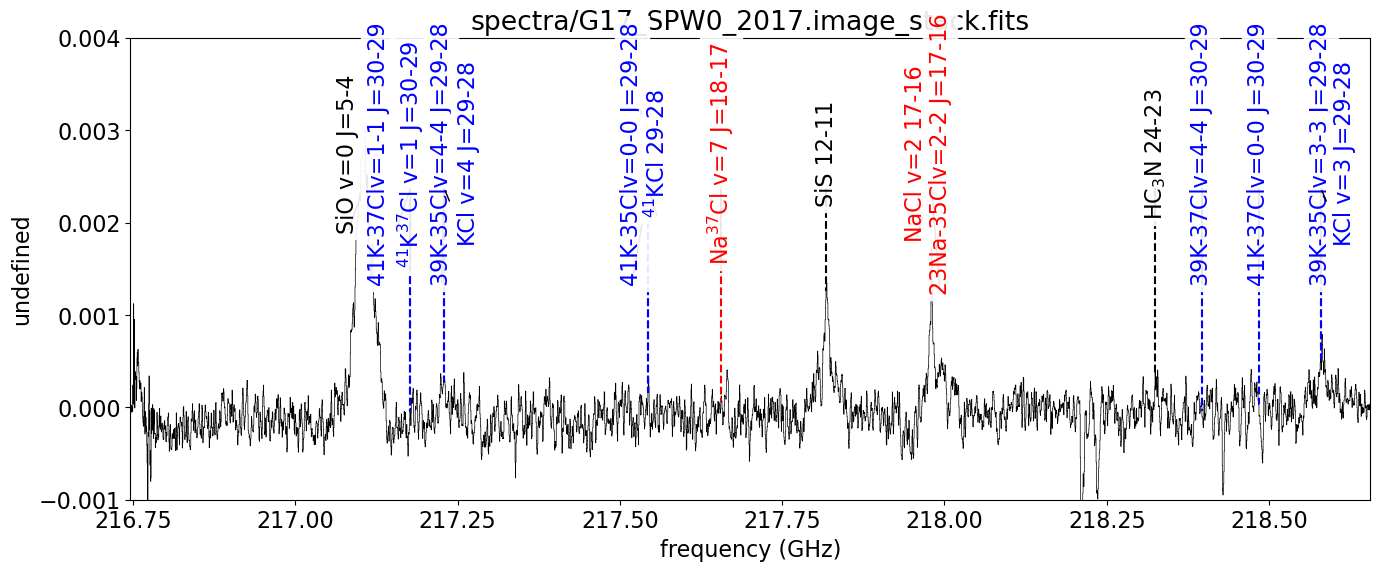

In [216]:
Image('spectra/figures/color_labels_G17_SPW0_2017.image_stack.png')

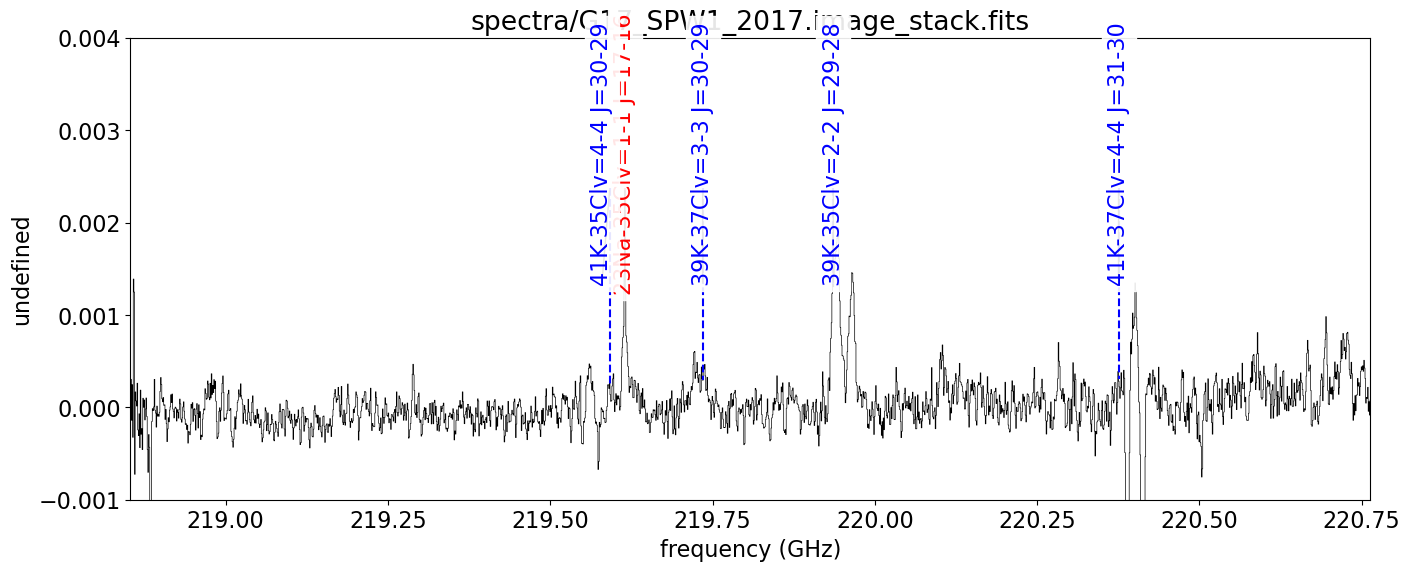

In [217]:
Image('spectra/figures/color_labels_G17_SPW1_2017.image_stack.png')

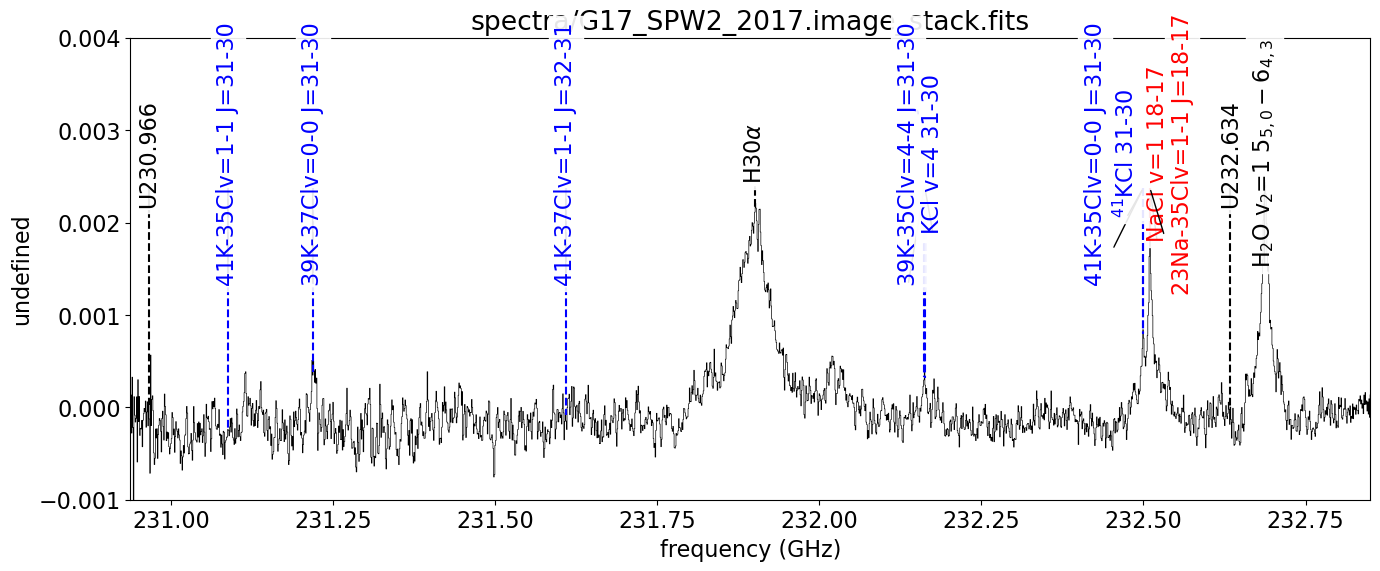

In [344]:
Image('spectra/figures/color_labels_G17_SPW2_2017.image_stack.png')

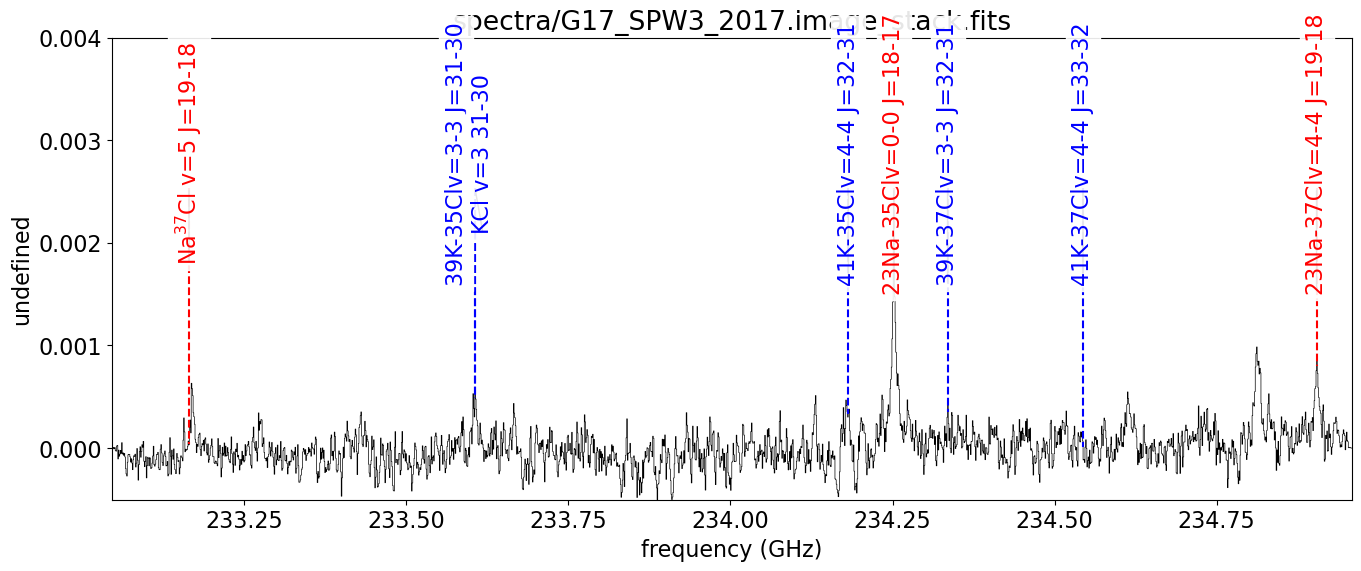

In [345]:
Image('spectra/figures/color_labels_G17_SPW3_2017.image_stack.png')

# Stack the KCl cubes to see if we come up with anything 

# KCl Stackl

In [332]:
# table 5 is double-rare, not detected
kcltables = salt_tables[:3]#  + salt_tables[5:]

In [322]:
# cubes are already loaded
# cubes = [SpectralCube.read(fn).subcube_from_regions([reg]) for fn in (glob.glob('G17_SPW[0-3]_2017.image.fits'))]
# beams = radio_beam.Beams(beams=[cube.beams.common_beam() for cube in cubes])
# cb=beams.common_beam()
linelistK = np.concatenate([data['Freq'][(data['vu'] <= 4) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)].quantity
                             for data in kcltables])
linenamesK = np.concatenate( [data['Species'][(data['vu'] <= 4) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)]
                             for data in kcltables] )
(linelistK, linenamesK)

(<Quantity [217.22891176, 218.5797076 , 219.93611261, 232.16184646,
            233.60569798, 218.39656825, 219.73475809, 231.21883931,
            234.33493148, 217.54316883, 219.59177028, 231.08814962,
            232.49980161, 234.18192351] GHz>,
 array(['39K-35Clv=4-4 J=29-28', '39K-35Clv=3-3 J=29-28',
        '39K-35Clv=2-2 J=29-28', '39K-35Clv=4-4 J=31-30',
        '39K-35Clv=3-3 J=31-30', '39K-37Clv=4-4 J=30-29',
        '39K-37Clv=3-3 J=30-29', '39K-37Clv=0-0 J=31-30',
        '39K-37Clv=3-3 J=32-31', '41K-35Clv=0-0 J=29-28',
        '41K-35Clv=4-4 J=30-29', '41K-35Clv=1-1 J=31-30',
        '41K-35Clv=0-0 J=31-30', '41K-35Clv=4-4 J=32-31'], dtype='<U25'))

In [323]:
rows = [data[(data['vu'] <= 4) &
             np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                      (data['Freq'].quantity < cube.spectral_extrema[1]))
                     for cube in cubes],
                    axis=0)]
        for data in kcltables]
KCl_inband = table.vstack(rows)
KCl_inband

upper_state,lower_state,Aij,Frequency_cm,Freq,E_U,E_L,QNs,vu,vl,Ju,Jl,gu,gl,Species
,,1 / s,1 / cm,GHz,K,K,,,,,,,,
int64,int64,float64,float64,float64,float64,float64,str17,int64,int64,int64,int64,int64,int64,str25
2037,2036,0.0065775,7.245516,217.22891175712175,1733.213093745079,1722.7884094074825,v=4-4 J=29-28,4,4,29,28,944,912,39K-35Clv=4-4 J=29-28
1535,1534,0.0066243,7.290563,218.57970759934983,1345.0583565643997,1334.5688596233451,v=3-3 J=29-28,3,3,29,28,944,912,39K-35Clv=3-3 J=29-28
1033,1032,0.0066713,7.335813,219.93611261476423,953.5558794307203,943.0012778144056,v=2-2 J=29-28,2,2,29,28,944,912,39K-35Clv=2-2 J=29-28
2039,2038,0.0080403,7.743592,232.16184645668199,1755.1374506752938,1743.9961458684122,v=4-4 J=31-30,4,4,31,30,1008,976,39K-35Clv=4-4 J=31-30
1537,1536,0.0080975,7.791745,233.60569798423805,1367.1190419652214,1355.9084557124208,v=3-3 J=31-30,3,3,31,30,1008,976,39K-35Clv=3-3 J=31-30
2038,2037,0.0066834,7.284444,218.3965682524781,1717.1701061368606,1706.689413074434,v=4-4 J=30-29,4,4,30,29,976,944,39K-37Clv=4-4 J=30-29
1536,1535,0.0067303,7.32908,219.7347580948684,1334.4294262712083,1323.8845119428167,v=3-3 J=30-29,3,3,30,29,976,944,39K-37Clv=3-3 J=30-29
32,31,0.0075851,7.712206,231.21883930648752,177.67434349526533,166.57819615441105,v=0-0 J=31-30,0,0,31,30,1008,976,39K-37Clv=0-0 J=31-30


In [346]:
# exclude lines with contaminants
# 41KCl v=4 J=30-20 is the worst, apparently, b/c of NaCl v=1 17-16
# 41KCl v=0 J=31-30 is on top of NaCl v=1 18-17
# KCl v=2 29-28 is double-peaked; not clear what's up there
# 41KCl v=0 J=29-28 just looks like a nondetection?
# 39K-37Cl v=4 J=30-29 nondetection
# 39K-37Cl v=3 J=32-31 nondetection
# 41K-35Cl v=1 J=31-30 nondetection
exclude = ('41K-35Clv=0-0 J=31-30',
           '41K-35Clv=4-4 J=30-29',
           '39K-35Clv=2-2 J=29-28',
           '41K-35Clv=0-0 J=29-28',
           '39K-37Clv=4-4 J=30-29',
           '39K-37Clv=3-3 J=32-31',
           '41K-35Clv=1-1 J=31-30',           
          )
incl = np.all([linenamesK != ex for ex in exclude], axis=0)
linelistK = linelistK[incl]
linenamesK = linenamesK[incl]
linelistK, linenamesK
pprint.pprint(dict(zip(linelistK, linenamesK)))

{<Quantity 217.22891176 GHz>: '39K-35Clv=4-4 J=29-28',
 <Quantity 218.5797076 GHz>: '39K-35Clv=3-3 J=29-28',
 <Quantity 219.73475809 GHz>: '39K-37Clv=3-3 J=30-29',
 <Quantity 231.21883931 GHz>: '39K-37Clv=0-0 J=31-30',
 <Quantity 232.16184646 GHz>: '39K-35Clv=4-4 J=31-30',
 <Quantity 233.60569798 GHz>: '39K-35Clv=3-3 J=31-30',
 <Quantity 234.18192351 GHz>: '41K-35Clv=4-4 J=32-31'}


In [347]:
stackK, cutoutsK = stack_cube(cubes,
                   linelist=linelistK,
                   vmin=-10*u.km/u.s,
                   vmax=50*u.km/u.s,
                   average=np.nanmean,
                   convolve_beam=cb,
                   return_cutouts=True)
stackK.writeto('KCl_v_le_4_stackcube.fits', overwrite=True)

Mean of empty slice


In [348]:
stackKc = SpectralCube.read('KCl_v_le_4_stackcube.fits')
stackKc

SpectralCube with shape=(90, 159, 160) and unit=Jy / beam:
 n_x:    160  type_x: RA---SIN  unit_x: deg    range:   275.609824 deg:  275.610051 deg
 n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -13.503435 deg:  -13.503215 deg
 n_s:     90  type_s: VRAD      unit_s: km / s  range:       -9.981 km / s:      49.996 km / s

In [349]:
regdisk = regions.Regions.read('diskmask.reg')

All-NaN slice encountered
invalid value encountered in true_divide


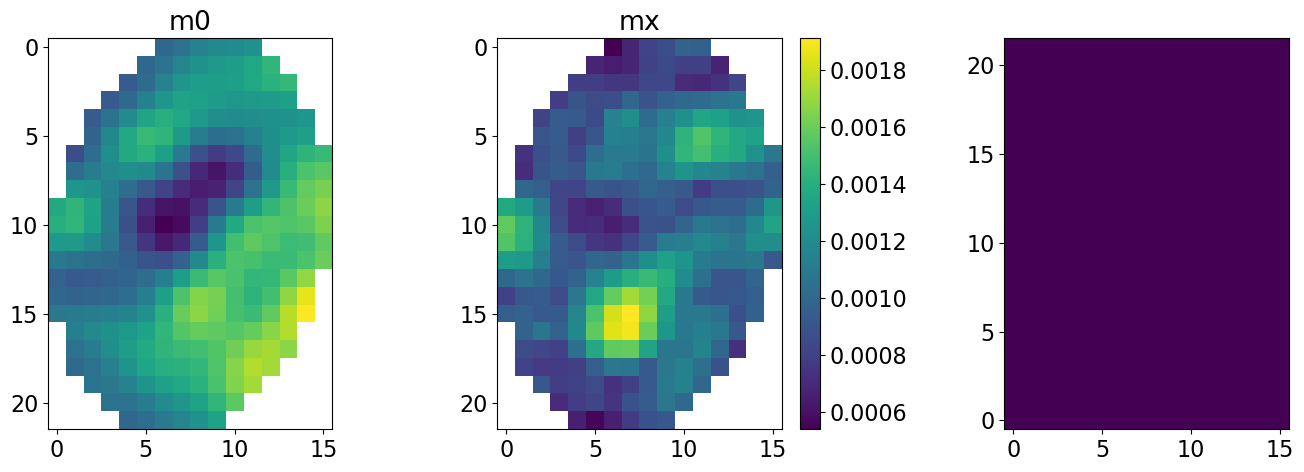

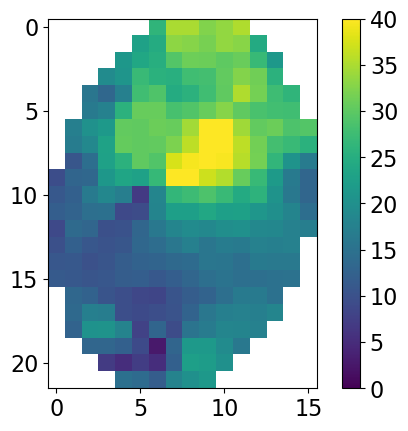

In [350]:
stackKc = stackKc.subcube_from_regions(regdisk)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = stackKc.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = stackKc.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
mskK = (mx) > 0.0001*mx.unit
mskK = scipy.ndimage.binary_erosion(mskK, iterations=1)
mskK = scipy.ndimage.binary_dilation(mskK, iterations=7)
pl.imshow(mskK, interpolation='none', origin='lower')
pl.tight_layout()
pl.figure()


m1 = stackKc.with_mask(mskK).with_mask(stackKc > 0.0005*stackKc.unit).moment1()
pl.imshow(m1.value, vmin=0, vmax=40)
pl.colorbar()
vmapK = m1.hdu

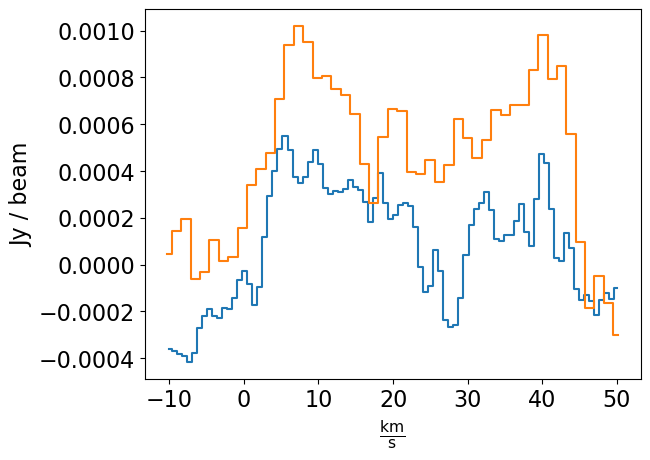

In [351]:
stackKc.mean(axis=(1,2)).quicklook()
stackc.with_mask(msk).mean(axis=(1,2)).quicklook()

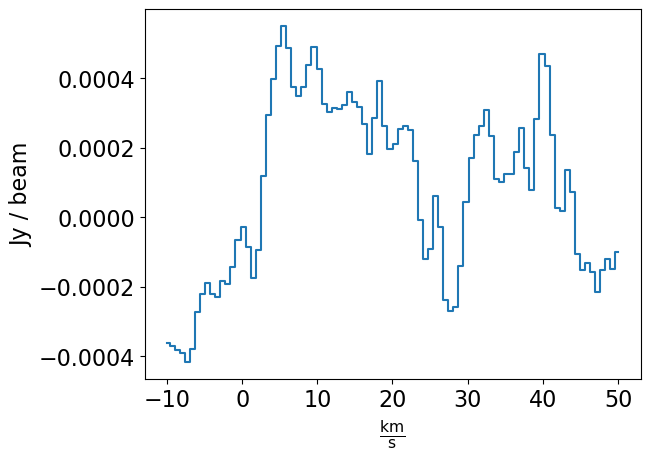

In [352]:
stackKc.with_mask(mskK).mean(axis=(1,2)).quicklook()

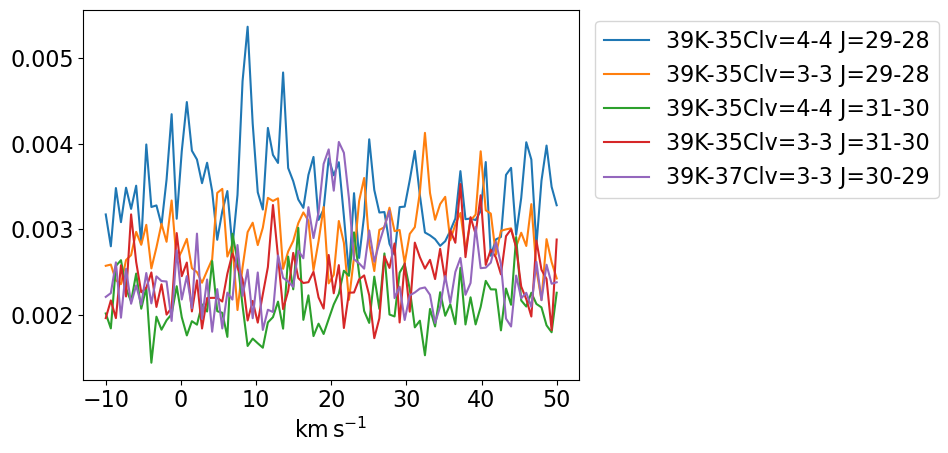

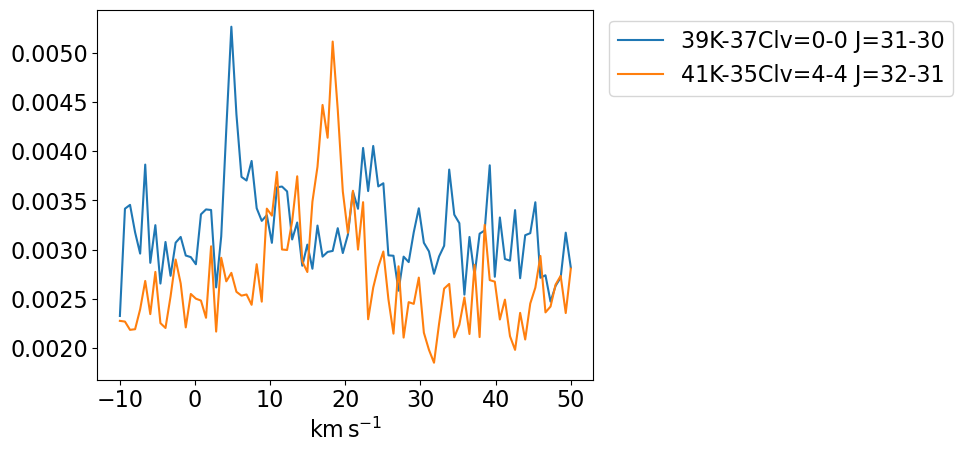

In [353]:
ii = 0
for cutout, linef in zip(cutoutsK, linenamesK):
    if ii == 5:
        pl.figure()
    cutout = SpectralCube(data=cutout, header=stackK.header, wcs=wcs.WCS(stackK.header)).subcube_from_regions([regvsm])
    sp = cutout.max(axis=(1,2))
    pl.plot(sp.spectral_axis, sp.value, label=str(linef))
    pl.legend(loc='upper left', bbox_to_anchor=(1.01,1,0,0))
    ii+=1

In [362]:
cubes[0].with_spectral_unit(u.km/u.s, velocity_convention='radio').spectral_axis.diff()

<Quantity [-1.25927148, -1.25927148, -1.25927148, ..., -1.25927148,
           -1.25927148, -1.25927148] km / s>

In [363]:
cubes[1].with_spectral_unit(u.km/u.s, velocity_convention='radio').spectral_axis.diff()

<Quantity [0.67005269, 0.67005269, 0.67005269, ..., 0.67005269, 0.67005269,
           0.67005269] km / s>

In [364]:
cubes[2].with_spectral_unit(u.km/u.s, velocity_convention='radio').spectral_axis.diff()

<Quantity [-1.24638837, -1.24638837, -1.24638837, ..., -1.24638837,
           -1.24638837, -1.24638837] km / s>

In [365]:
cubes[3].with_spectral_unit(u.km/u.s, velocity_convention='radio').spectral_axis.diff()

<Quantity [1.3312065, 1.3312065, 1.3312065, ..., 1.3312065, 1.3312065,
           1.3312065] km / s>

In [372]:
import sys
sys.path.append('/blue/adamginsburg/adamginsburg/repos/pvextractor',)

In [411]:
import show_pv

        Use `regions.Regions.read` instead. [constants]
        Use `regions.Regions.read` instead. [constants]


In [583]:
import pvextractor

In [584]:
endpts = regions.Regions.read('endpts.reg')

In [585]:
#crds = coordinates.SkyCoord(['18:22:26.38475', '18:22:26.3863'], ['-13:30:12.0346', '-13:30:11.9204'], unit=(u.hour, u.deg), frame='icrs')
crds = coordinates.SkyCoord([x.center for x in endpts])
path = pvextractor.Path(crds, width=0.02*u.arcsec)
crds, path

(<SkyCoord (ICRS): (ra, dec) in deg
     [(275.609945, -13.503297), (275.609931, -13.503363)]>,
 <pvextractor.geometry.path.Path at 0x2afaba106670>)

In [586]:
rslt = pvextractor.extract_pv_slice(cube=stackc, path=path)

(0.0, 47.0)

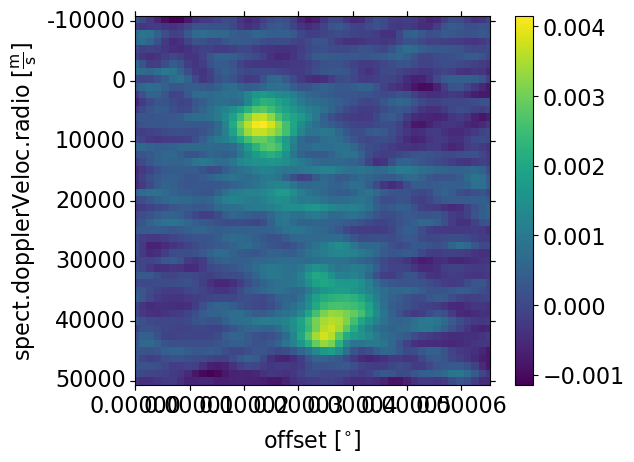

In [587]:
ww = wcs.WCS(rslt.header)
ax = pl.subplot(projection=ww)
im = ax.imshow(rslt.data)
pl.colorbar(im)
ax.set_xlim(0,47)

In [588]:
def show_pv(data, ww, origin, vrange, vcen, imvmin, imvmax, contour=False, distance=2.2*u.kpc):

    if ww.wcs.cunit[1] == 'm/s':
        scalefactor = 1000.0
    else:
        scalefactor = 1.0

    plotted_region = ww.wcs_world2pix([0,0],
                                      np.array(vrange)*scalefactor,
                                      0)
    plotted_slice = (slice(int(np.min(plotted_region[1])), int(np.max(plotted_region[1]))),
                     slice(None,None),
                    )

    fig = pl.figure(1, figsize=(8,8))
    fig.clf()
    ax = fig.add_axes([0.15, 0.1, 0.8, 0.8],projection=ww)
    assert ww.wcs.cunit[1] == 'm/s' # this is BAD BAD BAD but necessary

    good_limits = (np.array((np.argmax(np.isfinite(data.max(axis=0))),
                             data.shape[1] -
                             np.argmax(np.isfinite(data.max(axis=0)[::-1])) - 1
                            ))
                   )
    leftmost_position = ww.wcs_pix2world(good_limits[0],
                                         vrange[0]*scalefactor,
                                         0)[0]*u.arcsec
    rightmost_position = ww.wcs_pix2world(good_limits[1],
                                          vrange[0]*scalefactor,
                                          0)[0]*u.arcsec
    assert rightmost_position > 0
    maxdist = ((rightmost_position)*distance).to(u.au, u.dimensionless_angles())
    assert maxdist > 0
    print(f'leftmost: {leftmost_position}')
    print(f'rightmost: {rightmost_position}')



    #imvmin,imvmax = (np.nanmin(data[plotted_slice]),
    #                 np.nanmax(data[plotted_slice]))
    im = ax.imshow(data, cmap='gray_r',
                   vmin=imvmin, vmax=imvmax*1.1,
                   interpolation='none')
    ax.set_xlabel("Offset [\"]")
    ax.set_ylabel("$V_{LSR}$ [km/s]")

    if contour:
        std_est = stats.mad_std(data, ignore_nan=True)
        print("Estimate of standard deviation: {0}".format(std_est))
        con = ax.contour(data, colors=[contour]*5,
                         levels=np.array([5,10,15,20,25])*std_est,
                         linewidths=0.75)
    else:
        con = None
    

    trans = ax.get_transform('world')
    length = (50*u.au / (distance)).to(u.deg, u.dimensionless_angles())
    endpoints_x = u.Quantity([0.03*u.arcsec, 0.03*u.arcsec+length]) + leftmost_position
    print(f"endpoints_x = {endpoints_x}")
    ax.plot(endpoints_x.to(u.deg),
            ([vrange[0]+2]*2*u.km/u.s).to(u.m/u.s),
            'r',
            transform=trans,
            zorder=100, linewidth=2)
    ax.text(endpoints_x.to(u.deg).mean().value,
            (vrange[0]+3)*scalefactor,
            "50 au", color='r', transform=trans, ha='center')
    ax.plot(u.Quantity([leftmost_position, rightmost_position]).to(u.deg).value,
            u.Quantity([vcen,vcen]).to(u.m/u.s).value, 'w--', transform=trans)

    #ax.vlines(0,origin.to(u.deg).value,
    #          (vrange[0]-5)*scalefactor,
    #          (vrange[1]+5)*scalefactor,
    #          color='w', linestyle='--', linewidth=2.0,
    #          alpha=0.6, transform=trans)

    ax.set_xlim(good_limits)
    
    print(ww.wcs_world2pix(0,vrange[0]*scalefactor,0)[1],
          ww.wcs_world2pix(0,vrange[1]*scalefactor,0)[1])
    print(ax.get_ylim())
    print(ax.axis())

    ax.set_ylim(ww.wcs_world2pix(0,vrange[0]*scalefactor,0)[1],
                ww.wcs_world2pix(0,vrange[1]*scalefactor,0)[1])
    ax.set_xlim(good_limits)
    #ax2.set_xlim(good_limits)


    # ax.set_aspect(4)
    #ax.set_aspect(2*data.shape[1]/data.shape[0])
    aspect = 1*data.shape[1]/data.shape[0]
    ax.set_aspect(aspect)

    #ax.xticks(rotation=45)
    #ax.set_aspect('equal')

    ax.coords[1].set_format_unit(u.km/u.s)
    ax.coords[0].set_format_unit(u.arcsec)
    ax.coords[0].set_major_formatter('x.xx')
    
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    # https://stackoverflow.com/a/18195921/814354
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=-0.05)

    #cax = fig.add_axes([bb.x1+0.03, bb.y0, 0.05, bb.y1-bb.y0])

    #cb = pl.colorbar(im, cax=cax)
    #cb = pl.colorbar(mappable=im, ax=ax, pad=0.01, aspect=aspect*2)
    cb = pl.colorbar(mappable=im)
    pl.draw()
    bb = ax.bbox._bbox
    cb.ax.set_position([bb.x1+0.03, bb.y0, 0.05, bb.y1-bb.y0])

    ax.set_xlim(good_limits)
    ax.coords[0].set_ticklabel(exclude_overlapping=True, rotation=45, pad=45)

    return fig,ax,cb,con

leftmost: 0.0 arcsec
rightmost: 6.5277777777783e-05 arcsec
endpoints_x = [0.03       0.05272727] arcsec
47.77019029586154 0.12150818563009125
(-0.5, 48.5)
(0.0, 47.0, -0.5, 48.5)


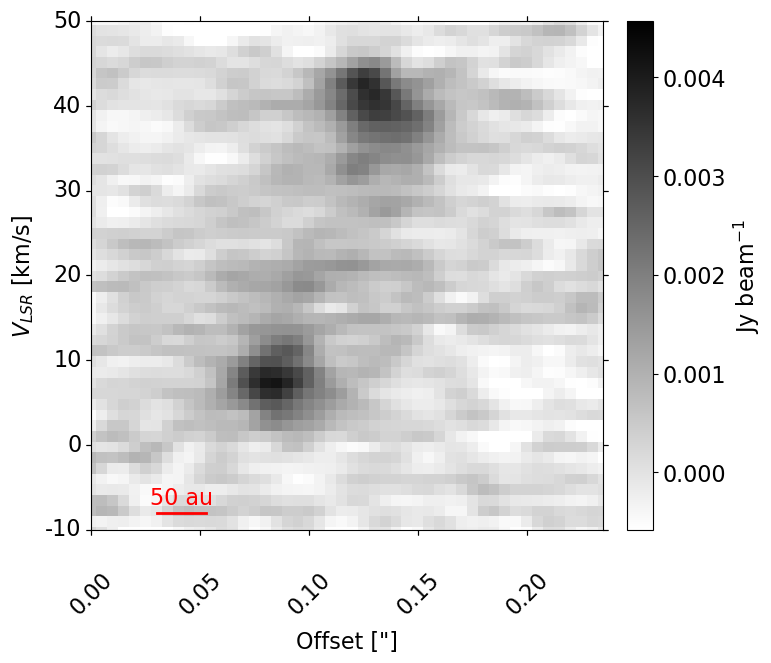

In [589]:
fig,ax,cb,con = show_pv(rslt.data, wcs.WCS(rslt.header), origin=coordinates.SkyCoord('18:22:26.3857', '-13:30:11.979', unit=(u.hour, u.deg), frame='icrs'),
                vrange=np.array([-10,50]), vcen=30*u.km/u.s, imvmin=np.nanpercentile(rslt.data, 3), imvmax=np.nanmax(rslt.data),
                    )
cb.set_label("Jy beam$^{-1}$")

In [596]:
stackKc2 = SpectralCube.read('KCl_v_le_4_stackcube.fits').subcube_from_regions([regvsm])
rsltK = pvextractor.extract_pv_slice(cube=stackKc2, path=path)

leftmost: 0.0 arcsec
rightmost: 6.5277777777783e-05 arcsec
endpoints_x = [0.03       0.05272727] arcsec
-0.028386684874931234 89.00582591123975
(-0.5, 89.5)
(0.0, 47.0, -0.5, 89.5)


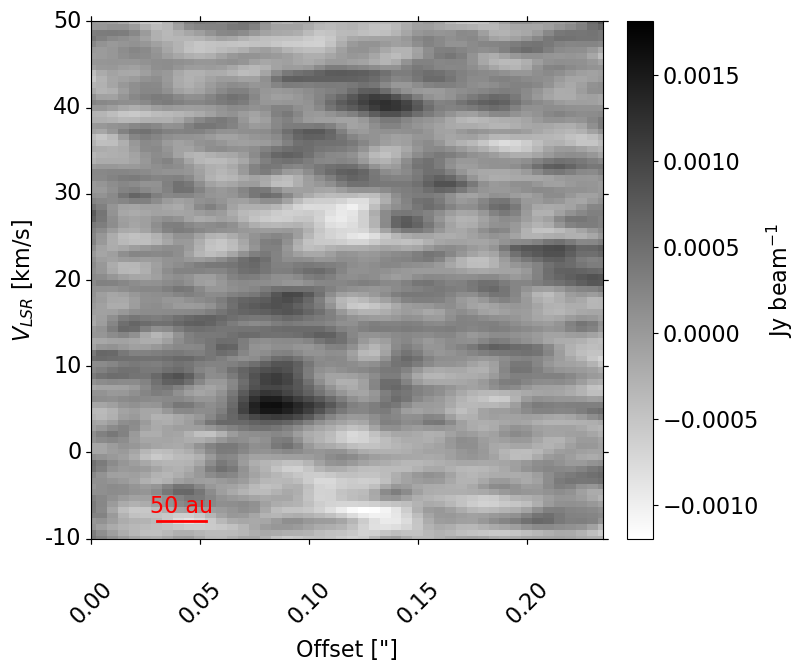

In [597]:
fig,ax,cb,con = show_pv(rsltK.data, wcs.WCS(rsltK.header), origin=coordinates.SkyCoord('18:22:26.3857', '-13:30:11.979', unit=(u.hour, u.deg), frame='icrs'),
                vrange=np.array([-10,50]), vcen=30*u.km/u.s, imvmin=np.nanmin(rsltK.data), imvmax=np.nanmax(rsltK.data),
                    )
cb.set_label("Jy beam$^{-1}$")